# diagnosis

The diagnosis table is used to track active problems for a given patient. It contains a list of diagnoses that were documented for each patient in the Active Diagnosis/Treatment sections of the eCareManager medical record. For some records, the corresponding International Classification of Diseases (ICD) codes are available. This can be useful for determining if certain diseases were documented during the ICU stay and at what point in the patient’s ICU stay these diagnoses were documented.

Important columns in this table include:

* `diagnosisstring` - the problem documented
* `icd9code` - a mapping from the problem to ICD-9 **and** ICD-10 code (the name of the column is antiquated)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [3]:
patientunitstayid = 2704494

In [7]:
query = query_schema + """
select *
from diagnosis
where patientunitstayid = {}
order by diagnosisoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df

,patientunitstayid,activeupondischarge,diagnosisid,diagnosisyear,diagnosistime24,diagnosistime,diagnosisoffset,diagnosisstring,icd9code,diagnosispriority
0,2704494,False,32722297,2014,05:13:31,morning,48,renal|disorder of kidney|acute renal failure,"584.9, N17.9",Major
1,2704494,False,31935854,2014,05:13:31,morning,48,oncology|chest tumors|breast CA|female,"174.9, C50.919",Major
2,2704494,False,33818792,2014,05:13:31,morning,48,cardiovascular|shock / hypotension|hypotension,"458.9, I95.9",Primary
3,2704494,False,32391279,2014,05:13:31,morning,48,oncology|hematologic malignancy|leukemia,,Major
4,2704494,False,33010439,2014,16:18:46,evening,2153,renal|disorder of kidney|acute renal failure,"584.9, N17.9",Major
5,2704494,False,33098216,2014,16:18:46,evening,2153,cardiovascular|shock / hypotension|hypotension,"458.9, I95.9",Primary
6,2704494,False,32825172,2014,16:18:46,evening,2153,oncology|chest tumors|breast CA|female,"174.9, C50.919",Major
7,2704494,False,33368560,2014,16:18:46,evening,2153,oncology|hematologic malignancy|leukemia,,Major
8,2704494,True,33376417,2014,16:24:51,evening,2159,cardiovascular|shock / hypotension|hypotension,"458.9, I95.9",Primary
9,2704494,True,32981160,2014,16:24:51,evening,2159,oncology|chest tumors|breast CA|female,"174.9, C50.919",Major


Here we can see that roughly on admission (`diagnosisoffset = 48` minutes after ICU admission), the patient had 4 problems documented:

* acute renal failure (major condition)
* breast cancer (major condition)
* shock/hypotension (primary condition)
* leukemia (major condition)

Later in the stay (`diagnosisoffset = 2153`), the same conditions are redocumented, and then finally a few minutes later (`diagnosisoffset = 2159`) these conditions are documented a final time with `activeupondischarge = True`, indicating that the patient was discharged with these conditions.

It's also worth noting that ICD-9 *and* ICD-10 codes are available with 3/4 of these diagnosis strings - only leukemia does not have matching codes. This often occurs because the `diagnosisstring` is at too high a level in the hierarchy, and so no appropriate ICD-9/ICD-10 code could be found. Let's look at this in more detail.

## ICD-9/ICD-10 code availability

In [9]:
dx = 'leukemia'
query = query_schema + """
select diagnosisstring, icd9code
, count(distinct patientunitstayid) as n
from diagnosis
where lower(diagnosisstring) like '%{}%'
group by diagnosisstring, icd9code
order by diagnosisstring, n desc
""".format(dx)

df = pd.read_sql_query(query, con)
df.head(n=10)

,diagnosisstring,icd9code,n
0,hematology|oncology and leukemia|carcinomatosis,"199.0, C80.0",5
1,hematology|oncology and leukemia|leukemia,,79
2,hematology|oncology and leukemia|leukemia|acut...,"204.00, C91.00",19
3,hematology|oncology and leukemia|leukemia|acut...,"204.01, C91.01",1
4,hematology|oncology and leukemia|leukemia|acut...,"205.00, C92.00",88
5,hematology|oncology and leukemia|leukemia|acut...,"205.01, C92.01",1
6,hematology|oncology and leukemia|leukemia|acut...,"205.00, C92.00",3
7,hematology|oncology and leukemia|leukemia|acut...,"205.00, C92.00",1
8,hematology|oncology and leukemia|leukemia|acut...,"205.00, C92.00",1
9,hematology|oncology and leukemia|leukemia|chro...,"204.10, C91.10",68


Above, we can see that the high level 'hematology|oncology and leukemia|leukemia' does not have an associated ICD-9/ICD-10 code, but the more granular values of 'hematology|oncology and leukemia|leukemia|acute lymphocytic', 'hematology|oncology and leukemia|leukemia|in remission', etc do have mappings to ICD-9/ICD-10 codes. Thus, if using ICD codes to define diagnoses, it is highly recommended to first find associated problems, then identify levels higher up in the hierarchy in order to capture all patients.

## Identifying patients using ICD-9/ICD-10 codes

Let's look at an example of finding patients using ICD-9/ICD-10 codes.

In [13]:
icd9 = '250.'
query = query_schema + """
select diagnosisstring, icd9code
, count(distinct patientunitstayid) as n
from diagnosis
where icd9code like '%{}%'
group by diagnosisstring, icd9code
order by diagnosisstring, n desc
""".format(icd9)

df = pd.read_sql_query(query, con)
df

,diagnosisstring,icd9code,n
0,endocrine|glucose metabolism|diabetes mellitus...,"250.01, E10.9",67
1,endocrine|glucose metabolism|diabetes mellitus...,"250.00, E11.9",678
2,endocrine|glucose metabolism|diabetes mellitus...,"250.02, E11.65",791
3,endocrine|glucose metabolism|diabetes mellitus...,"250.03, E10.65",211
4,endocrine|glucose metabolism|DKA,"250.13, E10.1",5024
5,endocrine|glucose metabolism|DKA|with altered ...,"250.33, E10.11",333
6,endocrine|glucose metabolism|hyperosmolar nonk...,"250.23, E13.00",148
7,endocrine|glucose metabolism|hyperosmolar nonk...,"250.22, E11.01",5


We have identified 8 rows, beginning with 'endocrine|glucose metabolism'. Let's modify our query to search for this phrase.

In [14]:
dx = 'endocrine|glucose metabolism'
query = query_schema + """
select diagnosisstring, icd9code
, count(distinct patientunitstayid) as n
from diagnosis
where diagnosisstring like '%{}%'
group by diagnosisstring, icd9code
order by diagnosisstring, n desc
""".format(dx)

df = pd.read_sql_query(query, con)
df

,diagnosisstring,icd9code,n
0,endocrine|glucose metabolism|diabetes mellitus,,14620
1,endocrine|glucose metabolism|diabetes mellitus...,,497
2,endocrine|glucose metabolism|diabetes mellitus...,"250.01, E10.9",67
3,endocrine|glucose metabolism|diabetes mellitus...,,3263
4,endocrine|glucose metabolism|diabetes mellitus...,"250.00, E11.9",678
5,endocrine|glucose metabolism|diabetes mellitus...,"250.02, E11.65",791
6,endocrine|glucose metabolism|diabetes mellitus...,"250.03, E10.65",211
7,endocrine|glucose metabolism|DKA,"250.13, E10.1",5024
8,endocrine|glucose metabolism|DKA|with altered ...,"250.33, E10.11",333
9,endocrine|glucose metabolism|hyperglycemia,"790.6, R73.9",5485


We now have 21 rows, and though not all are equivalent to diabetes, we do find that the top hit, 'endocrine|glucose metabolism|diabetes mellitus' has 14620 observations and is by far the most frequently documented problem for diagbetes, even though it does not have an ICD-9/ICD-10 code!

## Hospitals with data available

In [21]:
query = query_schema + """
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct dx.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join diagnosis dx
  on pt.patientunitstayid = dx.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
106,264,5237,4854,92.686653
184,420,4679,4463,95.383629
134,338,4277,4215,98.550386
90,243,4243,4090,96.394061
54,167,6092,3891,63.870650
11,73,7059,3800,53.831988
206,458,3701,3640,98.351797
200,443,3656,3595,98.331510
122,300,3617,3539,97.843517
80,208,3650,3428,93.917808


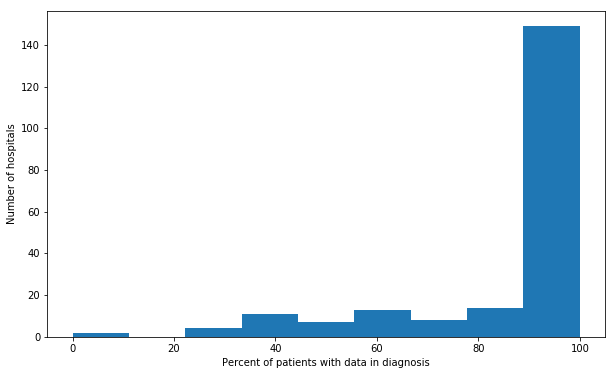

In [22]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in diagnosis')
plt.ylabel('Number of hospitals')
plt.show()

The diagnosis table is a core component of eICU Care Manager, and the majority of hospitals use this interface routinely. However, the particular use of it may vary. For example, we can ask: how many hospitals document problems on ICU discharge?

In [25]:
query = query_schema + """
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct dx.patientunitstayid) as number_of_patients_with_tbl
  , count(distinct case when dx.activeupondischarge = 'True' then dx.patientunitstayid else null end)
      as number_of_patients_with_active
from patient pt
left join diagnosis dx
  on pt.patientunitstayid = dx.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df['active dx completion'] = df['number_of_patients_with_active'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)
df.head()

,hospitalid,number_of_patients,number_of_patients_with_tbl,number_of_patients_with_active,data completion,active dx completion
0,56,325,135,133,41.538462,40.923077
1,58,321,138,136,42.990654,42.367601
2,59,854,303,292,35.480094,34.192037
3,60,458,177,165,38.646288,36.026201
4,61,233,98,97,42.060086,41.630901


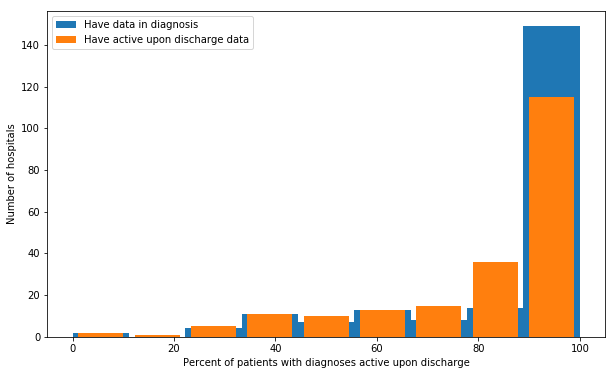

In [28]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10), rwidth=1,
        label='Have data in diagnosis')
plt.hist(df['active dx completion'], bins=np.linspace(0, 100, 10), rwidth=0.8,
        label='Have active upon discharge data')
plt.xlabel('Percent of patients with diagnoses active upon discharge')
plt.ylabel('Number of hospitals')
plt.legend(loc='upper left')
plt.show()

The number is reduced, indicating there are a few ICUs which do not routinely document diagnosis on discharge. Conversely, for a few hospitals, every patient may have a diagnosis documented on discharge.